This is the second of a series about bitcoin futures. We will look at historical prices for futures on Deribit.com to see if there are any trends and explore market efficiency.

- [Part 1 - Getting the data]({% post_url 2019-05-11-bitcoin-futures-arbitrage-part-1 %})
- [Part 2 - Were there arbitrage profits in the past?]({% post_url 2019-05-12-bitcoin-futures-arbitrage-part-2 %})
- [Part 3 - Perpetual futures 101]({% post_url 2019-05-20-bitcoin-futures-arbitrage-part-3 %})
- [Part 4 - Arbitrage Profit Analysis]({% post_url 2019-05-24-bitcoin-futures-arbitrage-part-4 %})

## Historical Future Price Data

Let's get into the data! I downloaded the sales price of every transaction for all Deribit futures in the last half of 2018 and 2019. I also downloaded the index price at each moment a sale was completed.

The data is processed and graphed below.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import glob
from IPython.core.pylabtools import figsize
import warnings
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [6]:
# Get a list of files with the historical data
files = glob.glob('downloads/futures/*.txt')

In [7]:
# Combine the files into one large pandas df
data_list = []
for file in files:
    data = pd.read_csv(file)
    data_list.append(data)
df_futures = pd.concat(data_list)

In [8]:
# Set the index to a timestamp
df_futures['date'] = pd.to_datetime(df_futures['timestamp'], unit='ms')
df_futures.index = df_futures['date']
df_futures = df_futures.drop(columns='date')

Here is a sample graph for the data of the BTC-29MAR19 future.

### Note
The instruments are named for their currency and expiry date. BTC-29MAR19 refers to a future based on the Bitcoin price and expires on the 29th of March, 2019.

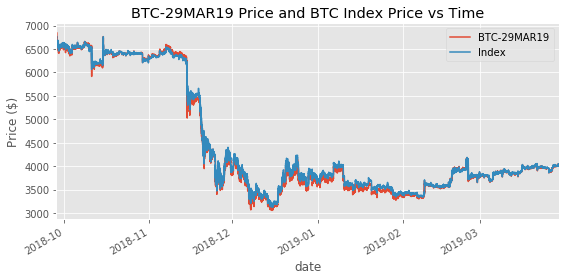

In [9]:
figsize(9, 4)
temp = df_futures[df_futures['instrument_name'] == 'BTC-29MAR19']
temp.columns = ['timestamp', 'instrument_name', 'BTC-29MAR19', 'Index']
temp.plot(y=['BTC-29MAR19', 'Index'])
plt.ylabel('Price ($)')
plt.title('BTC-29MAR19 Price and BTC Index Price vs Time')
plt.show()

The future tracks the index closely. The ratio of the prices will be useful for analysis.

In [10]:
df_futures['ratio'] = df_futures['price'] / df_futures['index_price']

In [11]:
instrument_names = ['BTC-27JUL18', 'BTC-31AUG18', 'BTC-28SEP18', 'BTC-28DEC18', 'BTC-29MAR19']

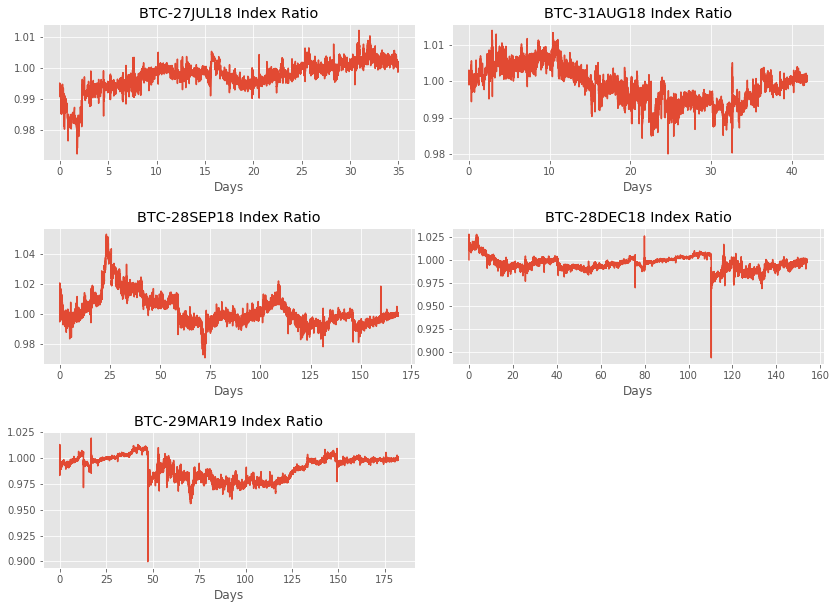

In [12]:
warnings.filterwarnings('ignore')
figsize(14, 10)
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i, instrument in enumerate(instrument_names):
    ax = fig.add_subplot(3, 2, i + 1)
    temp = df_futures[df_futures['instrument_name'] == instrument]
    temp['days'] = (temp['timestamp'] - temp['timestamp'][0]) / (1000 * 60 * 60 * 24)
    ax.plot(temp['days'], temp['ratio'])
    ax.set_xlabel('Days')
    ax.set_title(f'{instrument} Index Ratio')
plt.show()

Some futures were traded for a longer time than others. Deribit used to have futures rotating every month, and it has since moved to futures rotating every quarter. Hence the difference in the number of days of trading data. 

### Initial Observations

1. The futures contracts appear to follow the [convergence property](https://www.investopedia.com/terms/c/convergence.asp). The ratios tend to one as the contract gets closer to expiration. 
2. Some future prices may be correlated. In particular, the BTC-28DEC18 and the BTC-29MAR19 have a very similar drastic drop, that I bet lines up in time.

Let's test it.

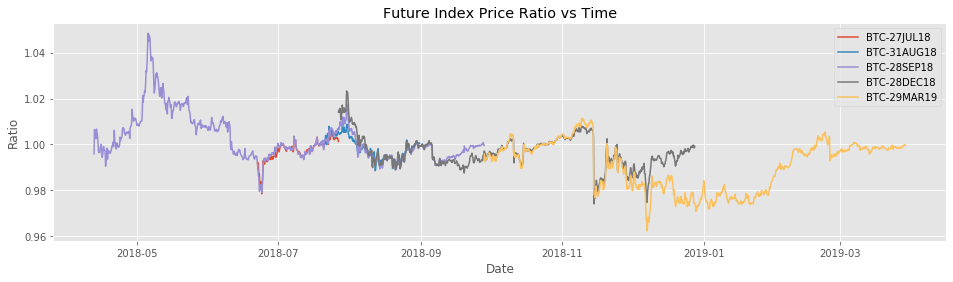

In [13]:
figsize(16, 4)
for i, instrument in enumerate(instrument_names):
    temp = df_futures[df_futures['instrument_name'] == instrument]
    temp = temp.resample('5H').mean()
    plt.plot(temp.index, temp['ratio'], label=instrument)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Future Index Price Ratio vs Time')
plt.show()

The prices are extremely correlated. The only divergence of greater than 1% is a short period at the end of 2018. The December 2018 future price was converging to 1, while the March 2019 future still had 3 months until expiration.

### Spot Futures Parity

My second major observation is that the futures prices do not appear to follow the spot futures parity theorem. It states that $F = S(1+r_f)$ when $F$ is the future price, $S$ is the spot price, and $r_f$ is the risk-free rate.

If a future perfectly followed this theoretical relationship, the price over time should look like the graph below.

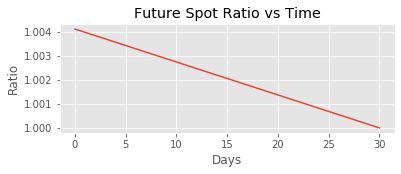

In [14]:
figsize(6, 2)
annual_rate = 0.05
daily_rate = annual_rate / 365
days = 30

xs = np.linspace(0, days, 1000)
ys = 1 + daily_rate * (days - xs)
plt.title('Future Spot Ratio vs Time')
plt.xlabel('Days')
plt.ylabel('Ratio')
plt.plot(xs, ys);

It's important to pay attention to the scale of the above graphs. There is a clear difference when the theoretical ratio is plotted alongside the real future index ratio.

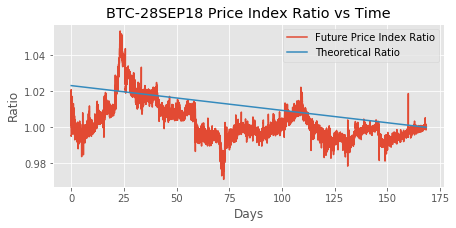

In [15]:
figsize(7, 3)
temp = df_futures.loc[df_futures['instrument_name'] == 'BTC-28SEP18',:]
temp.loc[:, 'days'] = (temp.loc[:,'timestamp'] - temp['timestamp'][0]) / (1000 * 60 * 60 * 24)

annual_rate = 0.05
daily_rate = annual_rate / 365
ys = 1 + daily_rate * (temp['days'][-1] - temp.loc[:, 'days'])
plt.xlabel('Days')
plt.ylabel('Ratio')
plt.plot(temp['days'], temp['ratio'], label='Future Price Index Ratio')
plt.plot(temp['days'], ys, label='Theoretical Ratio')
plt.legend(loc='upper right')
plt.title('BTC-28SEP18 Price Index Ratio vs Time')
plt.show()

Theoretical arbitrage profits can be earned any time the real ratio is above or below the theoretical ratio. But the appearance of profits often disappears once fees and transaction costs are taken into account.

So let's add in 1.5% transaction fees.

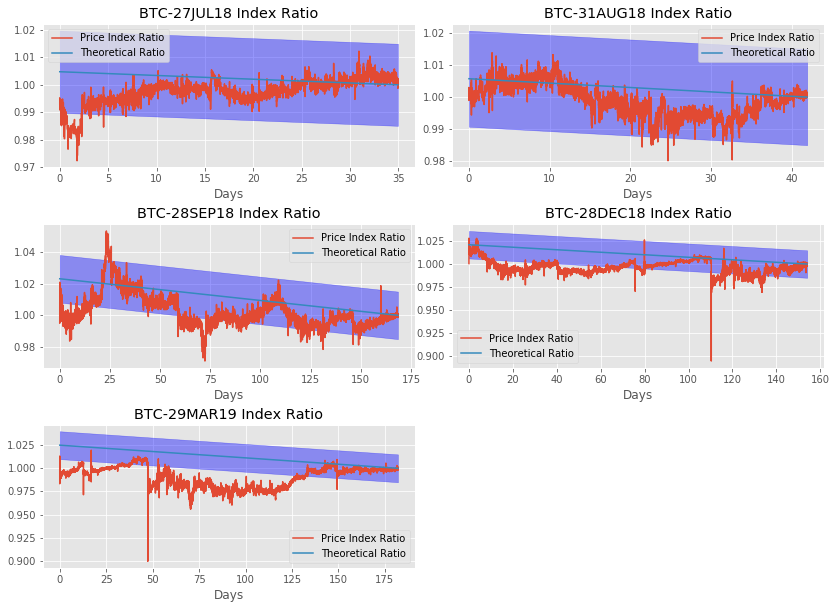

In [16]:
figsize(14, 10)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.1)

annual_rate = 0.05
daily_rate = annual_rate / 365

fees = 0.015

for i, instrument in enumerate(instrument_names):
    ax = fig.add_subplot(3, 2, i + 1)
    temp = df_futures.loc[df_futures['instrument_name'] == instrument,:]
    temp.loc[:, 'days'] = (temp.loc[:,'timestamp'] - temp['timestamp'][0]) / (1000 * 60 * 60 * 24)
    ys = 1 + daily_rate * (temp['days'][-1] - temp.loc[:, 'days'])
    lower = ys - fees
    upper = ys + fees
    ax.plot(temp['days'], temp['ratio'], label='Price Index Ratio')
    ax.plot(temp['days'], ys, label='Theoretical Ratio')
    ax.fill_between(temp['days'], lower, upper, color='b', alpha=0.4)
    ax.set_xlabel('Days')
    ax.set_title(f'{instrument} Index Ratio')
    ax.legend()
plt.show()

### Analysis

The blue ranges above are the no-arbitrage profit ranges. Any prices above or below the blue range should allow for arbitrage, given our assumptions.  Our estimate of 1.5% transaction fees is conservative. Deribit only charges 0.05% to buy or sell a future and 0.025% on the settlement. That means the sum of fees from buying or selling a future is deribit is 0.075%. That leaves a margin of 1.425% for transaction fees on buying or short selling bitcoin. This is plenty; most large exchanges charge less than 0.5% per transaction or less than 1% for the two transactions necessary to complete the arbitrage.

From this very simple analysis, it appears there may have been arbitrage opportunities. However the close correlation between the different futures prices compared to the index seems to suggest an efficient market, and a reason for the ratio being below or above the index, even if it was outside of our "arbitrage range". 

### Distribution of Ratios

Let's get an idea of the spread of the ratios. Below (and later in this report) I will use Kernel Density Estimate (KDE) plots. They are like fancy histograms.

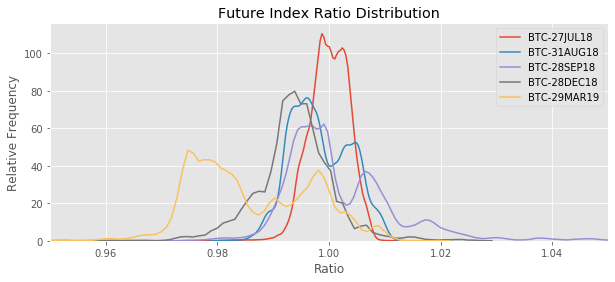

In [17]:
figsize(10,4)
for i, instrument in enumerate(instrument_names):
    temp = df_futures[df_futures['instrument_name'] == instrument]
    sns.kdeplot(temp['ratio'], label=instrument)
plt.xlabel('Ratio')
plt.ylabel('Relative Frequency')
plt.title('Future Index Ratio Distribution')
plt.xlim(0.95, 1.05)
plt.legend()   
plt.show()

### Strategies to Profit from Pricing Discrepancies

There are a few ways of attempting to arbitrage pricing errors. And to get any more detailed than our generic 5% risk-free rate assumption, we have to delve into the details of the particular strategy.

#### 1. Long/short futures and short/long bitcoins in the classic spot future arbitrage trade.

This is not risk-free. The futures settlement price is based on the Deribit bitcoin index. The bitcoin price you pay might differ from the Deribit index. This risk can be limited if you bought bitcoin at the specific exchanges in the proportion the exchanges contribute to the index. That would make your bitcoin portfolio 100% Deribit index tracking, but would likely be too much hassle.

The main issue is you have to factor in the real interest rates you will pay (instead of the generic 5% risk-free rate). This is particularly difficult for when the futures price is below the index and you have to short bitcoin. [Bitfinix](https://www.bitfinex.com/) is one of the largest exchanges that allows going short. A quick look at historical Bitfinex bitcoin margin interest rates at [https://bfxrates.com/] will show that the rates are quite volatile and have been as high as 30% and as low as 1% annually within the past 6 months.

The difficulty of shorting bitcoin could explain the tendency for the futures prices to be lower than my no-arbitrage ranges.

#### 2. Synthetic long/short using options

You can create a synthetic long/short with equal strike options. The options on deribit are based on the bitcoin index and thus provide exposure directly to the index.

#### 3. Long/short the perpetual

The market price of the perpetual future is expected to be quite close to the index and thus can also provide bitcoin exposure. This is a promising option because you can get both the future exposure and the bitcoin exposure on a margin. Traditional arbitrage assumes that you borrow \$1000, buy \$1000 of bitcoins and short the future. Using the perpetual you can get \$1000 of bitcoin exposure while only putting up \$10 of margin. This lowers the cost of capital and results in more arbitrage profit. 

I will expand on this strategy in later posts.

## Conclusion

We got our first taste of the market data. We see futures prices that are consistently different from their underlying and the theory. However different futures are quite highly correlated in how and when they diverge from the expected values.

In [Part 3]({% post_url 2019-05-20-bitcoin-futures-arbitrage-part-3 %}) I will look into using the perpetual as a method to arbitrage these price differences.